*WebMD* Drug Reviews Dataset;
Dataset of user reviews on various drugs;
https://www.kaggle.com/rohanharode07/webmd-drug-reviews-dataset


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
pd.set_option('max_colwidth', 500)

In [0]:
# ALL imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
import re
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
import seaborn as sns
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
dataframe = pd.read_csv("/content/drive/My Drive/nlp project dataset/webmd.csv")
dataframe.columns = dataframe.columns.str.lower()
dataframe.head()

,age,condition,date,drug,drugid,easeofuse,effectiveness,reviews,satisfaction,sex,sides,usefulcount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me. When I first began using this drug some years ago - tiredness as a problem but is not currently.,5,Male,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurting it went away after taking the medicine,5,Female,"Drowsiness, dizziness , dry mouth /nose/throat, headache , upset stomach , constipation , or trouble sleeping may occur.",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to over \n100?,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,"My grandfather was prescribed this medication (Coumadin) to assist in blood thinning due to a heart and thyroid condition. His primary doctor was aware that he was on an aspirin regiment and still prescribed this medicine, it caused his blood to thin out to much and he ended up internally bleeding to death. If you are going to take this medicine please ask your doctors about possible side effects or drug interactions.",1,Male,,1


In [0]:
dataframe.shape

(362806, 12)

In [0]:
dataframe = dataframe[dataframe['satisfaction']!=10]
dataframe = dataframe[dataframe['satisfaction']!=6]

In [0]:
dataframe.shape


(362803, 12)

In [0]:
df_train, df_test = train_test_split(dataframe, test_size=0.33, random_state=42) 
dataframe.shape, df_train.shape, df_test.shape

((362803, 12), (243078, 12), (119725, 12))

Now the data is loaded we can try sentiment analysis with bult-in VADER sentiment analyzer from the nltk library.

In [0]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
for sentence in dataframe['reviews'].values[:5]:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print()

I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me.  When I first began using this drug some years ago - tiredness as a problem but is not currently.
compound: 0.0891, neg: 0.044, neu: 0.904, pos: 0.052, 
cleared me right up even with my throat hurting it went away after taking the medicine
compound: -0.3182, neg: 0.149, neu: 0.773, pos: 0.077, 
why did my PTINR go from a normal of 2.5 to over 
100?
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, 
FALLING AND DON'T REALISE IT
compound: -0.1531, neg: 0.286, neu: 0.714, pos: 0.0, 
My grandfather was prescribed this medication (Coumadin) to assist in blood thinning due to a heart and thyroid condition.  His primary doctor was aware that he was on an aspirin regiment and still prescribed this medicine, it caused his blood to thin out to much and he ended up internally bleeding to death.  If you are going to take this medicine please ask your doctors about possib

In [0]:
# Snippet from:
# http://h6o6.com/2012/12/detecting-language-with-python-and-the-natural-language-toolkit-nltk/

from nltk.corpus import stopwords   # stopwords to detect language
from nltk import wordpunct_tokenize # function to split up our words

def get_language_likelihood(input_text):
    """Return a dictionary of languages and their likelihood of being the 
    natural language of the input text
    """
 
    input_text = input_text.lower()
    input_words = wordpunct_tokenize(input_text)
 
    language_likelihood = {}
    total_matches = 0
    for language in stopwords._fileids:
        language_likelihood[language] = len(set(input_words) &
                set(stopwords.words(language)))
 
    return language_likelihood
 
def get_language(input_text):
    """Return the most likely language of the given text
    """ 
    likelihoods = get_language_likelihood(input_text)
    return sorted(likelihoods, key=likelihoods.get, reverse=True)[0]

In [0]:
reviews_f = [r for r in dataframe['reviews'] if pd.notnull(r) and get_language(r) == 'english']

Generating polarity scores for the reviews.



In [0]:
pscores = [sid.polarity_scores(comment) for comment in reviews_f]


Neutral scores for the reviews

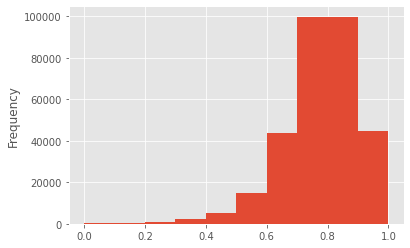

In [0]:
pd.Series([score['neu'] for score in pscores]).plot(kind='hist')




Positive scores for the reviews



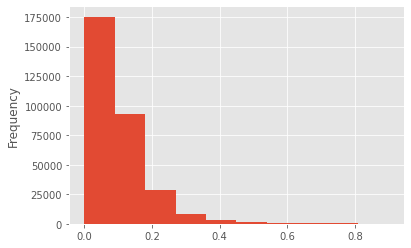

In [0]:
pd.Series([score['pos'] for score in pscores]).plot(kind='hist')


Reviews with negative scores

A significant amount of the reviews are given 0.0 negativity.

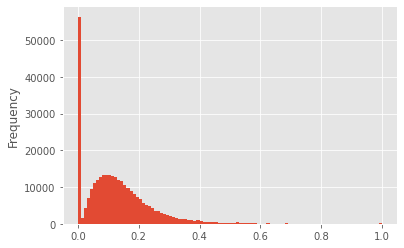

In [0]:
pd.Series([score['neg'] for score in pscores]).plot(kind='hist', bins=100)


In [0]:
scored_reviews = pd.DataFrame()
scored_reviews['review'] = [r for r in reviews_f if get_language(r) == 'english']
scored_reviews['compound'] = [score['compound'] for score in pscores]
scored_reviews['negativity'] = [score['neg'] for score in pscores]
scored_reviews['neutrality'] = [score['neu'] for score in pscores]
scored_reviews['positivity'] = [score['pos'] for score in pscores]

In [0]:
scored_reviews.head()


,review,compound,negativity,neutrality,positivity
0,I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me. When I first began using this drug some years ago - tiredness as a problem but is not currently.,0.0891,0.044,0.904,0.052
1,cleared me right up even with my throat hurting it went away after taking the medicine,-0.3182,0.149,0.773,0.077
2,why did my PTINR go from a normal of 2.5 to over \n100?,0.0000,0.000,1.000,0.000
3,FALLING AND DON'T REALISE IT,-0.1531,0.286,0.714,0.000
4,"My grandfather was prescribed this medication (Coumadin) to assist in blood thinning due to a heart and thyroid condition. His primary doctor was aware that he was on an aspirin regiment and still prescribed this medicine, it caused his blood to thin out to much and he ended up internally bleeding to death. If you are going to take this medicine please ask your doctors about possible side effects or drug interactions.",-0.3818,0.052,0.918,0.031


Let's look at our positive-negativity reviews. Some of them aren't negative at all.



In [0]:
scored_reviews.query('negativity > 0')


,review,compound,negativity,neutrality,positivity
0,I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me. When I first began using this drug some years ago - tiredness as a problem but is not currently.,0.0891,0.044,0.904,0.052
1,cleared me right up even with my throat hurting it went away after taking the medicine,-0.3182,0.149,0.773,0.077
3,FALLING AND DON'T REALISE IT,-0.1531,0.286,0.714,0.000
4,"My grandfather was prescribed this medication (Coumadin) to assist in blood thinning due to a heart and thyroid condition. His primary doctor was aware that he was on an aspirin regiment and still prescribed this medicine, it caused his blood to thin out to much and he ended up internally bleeding to death. If you are going to take this medicine please ask your doctors about possible side effects or drug interactions.",-0.3818,0.052,0.918,0.031
5,"Haven't gotten pregnant so it does it's job. I was switched to this brand from another generic. I get nauseous and generally feel tired on this, also more headaches.",-0.4404,0.100,0.900,0.000
...,...,...,...,...,...
311005,I took the whole 12 weeks.I could have stopped the drug sooner but thought i'd just go the whole 12 weeks. I had no weird dreams. I really didnt have any side effects I think because I was taking wellbutrin also.I stopped June 16th of 2006 and havent had a cigerette since then.,-0.4767,0.160,0.775,0.065
311006,"My dad strated taking Chantix about 1 month ago and he was doing fine, he stopped smoking but he had all the sideeffects listed. I got a phone call from my stepmother saying that he has been hopitalized because of crazy suicidal thoughts. My father is not the type of person to harm anyone let alone himself. If anyone has had the same symptoms please let me know im very worried.",-0.9580,0.249,0.701,0.051
311007,"As long as I was on chantix, I didn't smoke. Terrible stomach upset after each dose, constipation, headaches constantly, crazy dreams and mood swings. I have had to stop taking it and have found other ways to stop smoking.",-0.4847,0.211,0.672,0.118
311008,"Started this medication Oct 5th 2008. Haven't smoked for 6 weeks and planning on the full 12 weeks program. I have had some problems like getting sick after the meds but accually it helps because everytime I see a smoker or smell smoke I get sick, still want one but it offsets it.",-0.4310,0.148,0.736,0.116


Here are two that are:



In [0]:
scored_reviews.iloc[23]['review']


'Right after starting this pill I began gaining weight and I know this was the culprit! I was bloated all the time and extremely moody- sort of like I was just about to start my period constantly. Not the mention the spotting I had about 50% of the time randomly. I absolutely hated this pill and would not recommend. '

In [0]:
scored_reviews.iloc[23]['compound']

-0.6584

In [0]:
scored_reviews.query('negativity > positivity').query('negativity > 0.1')


,review,compound,negativity,neutrality,positivity
1,cleared me right up even with my throat hurting it went away after taking the medicine,-0.3182,0.149,0.773,0.077
3,FALLING AND DON'T REALISE IT,-0.1531,0.286,0.714,0.000
6,I have take this for 5 years age 45-50 to prevent ovarian cysts (I had 2 burst). Now stopped because of age. No side effects.,-0.4588,0.169,0.785,0.045
9,"Taking Lyza made me break out HORRIBLY. I tried it out for 3 months and then it was so bad that I stopped taking it. Itâ??s inceedible how much it damaged my skin in only 3 months. Now itâ??s been 3 months since I stopped taking it and my skin is way better but i still have acne and i have really bad scars. I definitely would not take this again. Besides the acne, while taking Lyza I started to not get me periods anymore starting about the 3rd month. Everything else was fine. It didnâ??t giv...",-0.7413,0.156,0.744,0.100
10,"This stuff needs to be removed from the market! It’s so harmful and ages you fast!! \nI have dark racoon eyes, and dark marks all over my neck.\nShortness of breath\nHorrible mood swings\nHorrible acne \nEnlarged poors \nAnd hair loss. Avoid this birth control because it literally IS THE PLAGUE!",-0.9130,0.216,0.784,0.000
...,...,...,...,...,...
311001,"I took it for two days and had an allergic reaction to it. My chest and back had an itchy rash on it, as well as my face. My lips dried out. Very uncomfortable experience. What a waste of good money.",-0.7713,0.255,0.644,0.101
311005,I took the whole 12 weeks.I could have stopped the drug sooner but thought i'd just go the whole 12 weeks. I had no weird dreams. I really didnt have any side effects I think because I was taking wellbutrin also.I stopped June 16th of 2006 and havent had a cigerette since then.,-0.4767,0.160,0.775,0.065
311006,"My dad strated taking Chantix about 1 month ago and he was doing fine, he stopped smoking but he had all the sideeffects listed. I got a phone call from my stepmother saying that he has been hopitalized because of crazy suicidal thoughts. My father is not the type of person to harm anyone let alone himself. If anyone has had the same symptoms please let me know im very worried.",-0.9580,0.249,0.701,0.051
311007,"As long as I was on chantix, I didn't smoke. Terrible stomach upset after each dose, constipation, headaches constantly, crazy dreams and mood swings. I have had to stop taking it and have found other ways to stop smoking.",-0.4847,0.211,0.672,0.118


In [0]:
scored_reviews.query('negativity > positivity').query('compound < -0.2')


,review,compound,negativity,neutrality,positivity
1,cleared me right up even with my throat hurting it went away after taking the medicine,-0.3182,0.149,0.773,0.077
4,"My grandfather was prescribed this medication (Coumadin) to assist in blood thinning due to a heart and thyroid condition. His primary doctor was aware that he was on an aspirin regiment and still prescribed this medicine, it caused his blood to thin out to much and he ended up internally bleeding to death. If you are going to take this medicine please ask your doctors about possible side effects or drug interactions.",-0.3818,0.052,0.918,0.031
5,"Haven't gotten pregnant so it does it's job. I was switched to this brand from another generic. I get nauseous and generally feel tired on this, also more headaches.",-0.4404,0.100,0.900,0.000
6,I have take this for 5 years age 45-50 to prevent ovarian cysts (I had 2 burst). Now stopped because of age. No side effects.,-0.4588,0.169,0.785,0.045
9,"Taking Lyza made me break out HORRIBLY. I tried it out for 3 months and then it was so bad that I stopped taking it. Itâ??s inceedible how much it damaged my skin in only 3 months. Now itâ??s been 3 months since I stopped taking it and my skin is way better but i still have acne and i have really bad scars. I definitely would not take this again. Besides the acne, while taking Lyza I started to not get me periods anymore starting about the 3rd month. Everything else was fine. It didnâ??t giv...",-0.7413,0.156,0.744,0.100
...,...,...,...,...,...
311001,"I took it for two days and had an allergic reaction to it. My chest and back had an itchy rash on it, as well as my face. My lips dried out. Very uncomfortable experience. What a waste of good money.",-0.7713,0.255,0.644,0.101
311005,I took the whole 12 weeks.I could have stopped the drug sooner but thought i'd just go the whole 12 weeks. I had no weird dreams. I really didnt have any side effects I think because I was taking wellbutrin also.I stopped June 16th of 2006 and havent had a cigerette since then.,-0.4767,0.160,0.775,0.065
311006,"My dad strated taking Chantix about 1 month ago and he was doing fine, he stopped smoking but he had all the sideeffects listed. I got a phone call from my stepmother saying that he has been hopitalized because of crazy suicidal thoughts. My father is not the type of person to harm anyone let alone himself. If anyone has had the same symptoms please let me know im very worried.",-0.9580,0.249,0.701,0.051
311007,"As long as I was on chantix, I didn't smoke. Terrible stomach upset after each dose, constipation, headaches constantly, crazy dreams and mood swings. I have had to stop taking it and have found other ways to stop smoking.",-0.4847,0.211,0.672,0.118


In [0]:
scored_reviews.iloc[1181]['review']


"Has stopped my knee pain I've had for years in its tract. Yeah for me!! No side effects as of yet!!"

In [0]:
scored_reviews.iloc[1181]

review        Has stopped my knee pain I've had for years in its tract. Yeah for me!! No side effects as of yet!!
compound                                                                                                  -0.7482
negativity                                                                                                  0.309
neutrality                                                                                                  0.612
positivity                                                                                                  0.079
Name: 1181, dtype: object

The results are not very good, so we move on with different techniques for sentiment classification.

In [0]:
import string
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
dataframe = pd.read_csv("/content/drive/My Drive/nlp project dataset/webmd.csv")
dataframe.columns = dataframe.columns.str.lower()
dataframe.head()

,age,condition,date,drug,drugid,easeofuse,effectiveness,reviews,satisfaction,sex,sides,usefulcount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [0]:
dataframe.shape

(362806, 12)

In [0]:
dataframe = dataframe[dataframe['satisfaction']!=10]
dataframe = dataframe[dataframe['satisfaction']!=6]

In [0]:
dataframe.shape

(362803, 12)

In [0]:
df_train, df_test = train_test_split(dataframe, test_size=0.33, random_state=42) 
dataframe.shape, df_train.shape, df_test.shape

((362803, 12), (243078, 12), (119725, 12))

In [0]:
dataframe.describe(include='all')
print("Shape of the dataset:")
print(dataframe.shape) #size of the data corpus
print("Column names:")
print(dataframe.columns)
print("Datatype of each column:")
print(dataframe.dtypes)
print("Sample of the data:")
print(dataframe.head())



Shape of the dataset:
(362803, 12)
Column names:
Index(['age', 'condition', 'date', 'drug', 'drugid', 'easeofuse',
       'effectiveness', 'reviews', 'satisfaction', 'sex', 'sides',
       'usefulcount'],
      dtype='object')
Datatype of each column:
age              object
condition        object
date             object
drug             object
drugid            int64
easeofuse         int64
effectiveness     int64
reviews          object
satisfaction      int64
sex              object
sides            object
usefulcount       int64
dtype: object
Few dataset entries:
          age  ... usefulcount
0  75 or over  ...           0
1       25-34  ...           1
2       65-74  ...           0
3  75 or over  ...           0
4       35-44  ...           1

[5 rows x 12 columns]


,age,condition,date,drug,drugid,easeofuse,effectiveness,reviews,satisfaction,sex,sides,usefulcount
count,362803,362803,362803,362803,362803.000000,362803.000000,362803.000000,362766,362803.000000,362803,362803,362803.000000
unique,12,1806,4524,7093,NaN,NaN,NaN,250166,NaN,3,1651,NaN
top,45-54,Other,10/29/2007,cymbalta,NaN,NaN,NaN,,NaN,Female,,NaN
freq,80042,49764,404,4648,NaN,NaN,NaN,41824,NaN,238224,17460,NaN
mean,NaN,NaN,NaN,NaN,36879.589154,4.019801,3.532030,NaN,3.135374,NaN,NaN,6.744958
std,NaN,NaN,NaN,NaN,52624.573202,1.317671,1.455916,NaN,1.611058,NaN,NaN,9.324264
min,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,1.000000,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,4896.000000,3.000000,3.000000,NaN,1.000000,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,9548.000000,5.000000,4.000000,NaN,3.000000,NaN,NaN,4.000000
75%,NaN,NaN,NaN,NaN,63522.000000,5.000000,5.000000,NaN,5.000000,NaN,NaN,9.000000


The new column will be - "length". This column will hold the data of the word length of the review.



In [0]:
#adding a column named length for the number of words in the review
dataframe['reviews']=dataframe['reviews'].astype(str)
dataframe['length'] = dataframe['reviews'].apply(len)
dataframe.head()

,age,condition,date,drug,drugid,easeofuse,effectiveness,reviews,satisfaction,sex,sides,usefulcount,length
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0,231
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1,86
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0,54
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0,28
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1,423


As the graphs show, the extreme ratings for satisfaction (grade 1 and grade 5) are slightly longer than the reviews with ratings 2, 3 or 4.

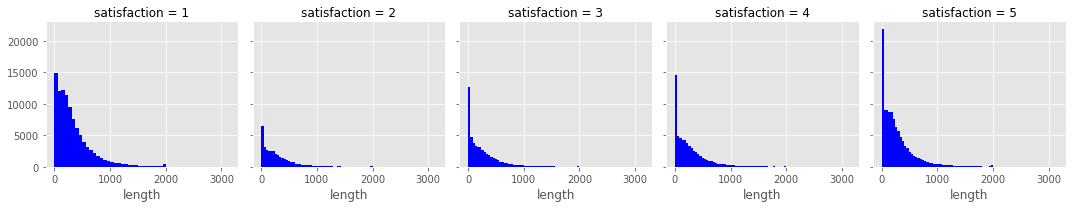

In [0]:
# visual representation of the connection between satisfaction rating and the number of words of the review
graph = sns.FacetGrid(data=dataframe,col='satisfaction')
graph.map(plt.hist,'length',bins=50,color='blue')

ease of use, effectiovness and useful count are anoter three columns which describe the data. lets see their means in comparisson with the satisfaction value


In [0]:
# GETTING THE MEAN VALUES OF THE VOTE COLUMNS WRT THE STARS ON THE REVIEW
stval = dataframe.groupby('satisfaction').mean()
stval

,drugid,easeofuse,effectiveness,usefulcount,length
satisfaction,,,,,
1,41578.189195,2.976452,1.927830,7.241167,344.279601
2,35337.325364,3.689887,2.966470,5.712127,287.194924
3,32747.298214,4.011494,3.477995,5.288301,266.777791
4,33376.030226,4.380490,4.134156,6.077932,283.832579
5,37022.651179,4.867719,4.846472,7.678108,281.138861


In [0]:
# FINDING THE CORRELATION BETWEEN THE VOTE COLUMNS
stval.corr()

,drugid,easeofuse,effectiveness,usefulcount,length
drugid,1.000000,-0.559141,-0.547220,0.756964,0.915069
easeofuse,-0.559141,1.000000,0.999379,0.111982,-0.758625
effectiveness,-0.547220,0.999379,1.000000,0.128920,-0.741252
usefulcount,0.756964,0.111982,0.128920,1.000000,0.525770
length,0.915069,-0.758625,-0.741252,0.525770,1.000000


In [0]:
# CLASSIFICATION
data_classes = dataframe[(dataframe['satisfaction']==1) | (dataframe['satisfaction']==3) | (dataframe['satisfaction']==5)]
data_classes.head()
print(data_classes.shape)

# Separate the dataset into X and Y
x = data_classes['reviews']
y = data_classes['satisfaction']
print(x.head())
print(y.head())

(264303, 13)
0    I'm a retired physician and of all the meds I ...
1    cleared me right up even with my throat hurtin...
2    why did my PTINR go from a normal of 2.5 to ov...
3                         FALLING AND DON'T REALISE IT
4    My grandfather was prescribed this medication ...
Name: reviews, dtype: object
0    5
1    5
2    3
3    1
4    1
Name: satisfaction, dtype: int64


We will now, define a function which will clean the dataset by removing stopwords and punctuations.

In [0]:
# CLEANING THE REVIEWS - REMOVAL OF STOPWORDS AND PUNCTUATION
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

We will now vectorize a single review and see the results:



In [0]:
# CONVERTING THE WORDS INTO A VECTOR
vocab = CountVectorizer(analyzer=text_process).fit(x)
print(len(vocab.vocabulary_))
r0 = x[0]
print(r0)
vocab0 = vocab.transform([r0])
print(vocab0)
"""
    Now the words in the review number 78 have been converted into a vector.
    The data that we can see is the transformed words.
    If we now get the feature's name - we can get the word back!
"""
print("Getting the words back:")
print(vocab.get_feature_names()[19648])
print(vocab.get_feature_names()[10643])


182582
I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me.  When I first began using this drug some years ago - tiredness as a problem but is not currently.
  (0, 32887)	1
  (0, 61769)	1
  (0, 62558)	1
  (0, 70020)	1
  (0, 82786)	1
  (0, 91328)	1
  (0, 93030)	1
  (0, 100290)	1
  (0, 124512)	1
  (0, 134968)	1
  (0, 140878)	1
  (0, 144326)	1
  (0, 150477)	1
  (0, 153306)	1
  (0, 168727)	1
  (0, 170807)	1
  (0, 173870)	1
  (0, 180915)	1
Getting the words back:
CROSS
6months


(10). Vectorization of the whole review set and and checking the sparse matrix:



In [0]:
x = vocab.transform(x)
#Shape of the matrix:
print("Shape of the sparse matrix: ", x.shape)
#Non-zero occurences:
print("Non-Zero occurences: ",x.nnz)

# DENSITY OF THE MATRIX
density = (x.nnz/(x.shape[0]*x.shape[1]))*100
print("Density of the matrix = ",density)

Shape of the sparse matrix:  (264303, 182582)
Non-Zero occurences:  6773848
Density of the matrix =  0.014037035378375098


(11). Splitting the dataset X into training and testing set:



In [0]:
# SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=101)

MODELS

We will now use multiple Machine Algorithms to see which gives the best performance.



(1). Multinomial Naive Bayes - We are using Multinomial Naive Bayes over Gaussian because with sparse data, Gaussian Naive Bayes assumptions aren't met and a simple gaussian fit over the data will not give us a good fit or prediction!

In [0]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train,y_train)
predmnb = mnb.predict(x_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:",classification_report(y_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[15120  1178  3851]
 [ 3030  2399  4803]
 [ 2625  1025 18830]]
Score: 68.76
Classification Report:               precision    recall  f1-score   support

           1       0.73      0.75      0.74     20149
           3       0.52      0.23      0.32     10232
           5       0.69      0.84      0.75     22480

    accuracy                           0.69     52861
   macro avg       0.64      0.61      0.61     52861
weighted avg       0.67      0.69      0.66     52861



In [0]:
review= dataframe['reviews'][0]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][0])
review_t = vocab.transform([review])
print("Predicted Rating:")
mnb.predict(review_t)[0]

I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me.  When I first began using this drug some years ago - tiredness as a problem but is not currently.
Actual Rating:  5
Predicted Rating:


5

In [0]:
review = dataframe['reviews'][2]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][2])
review_t = vocab.transform([review])
print("Predicted Rating:")
mnb.predict(review_t)[0]

why did my PTINR go from a normal of 2.5 to over 
100?
Actual Rating:  3
Predicted Rating:


5

In [0]:
review = dataframe['reviews'][24]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][24])
review_t = vocab.transform([review])
print("Predicted Rating:")
mnb.predict(review_t)[0]

I switched from the Mirena to Lyza and the relief from horrendous cramps was amazing and instantaneous. However, I have noticed slight weight gain (about 5 pounds), and have had severely tender breasts. Sometimes it will last over 1 month and they are sore to the point that moving my arms makes me cringe. The only other major side effect has been frequent bleeding and much heavier periods than usual.  I normally have a fairly light, short period (2 days normal bleeding, 1-2 of spotting). But there have been two occasions since starting Lyza in which I have woken up in a pool of blood on the bed because the bleeding is so heavy and unexpected. There has been some bloating as well, but I'm not sure if that is due to the pill because I had the same issue with Mirena. I have my suspicions about ovarian cysts, so that could be causing the bloating, breast tenderness, and abnormal bleeding. I rated ease of use as one star because it has been very difficult for me to remember to take the pill

3

(2). Random Forest Classifier



In [0]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
%time rmfr.fit(x_train,y_train)
predrmfr = rmfr.predict(x_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
print("Classification Report:",classification_report(y_test,predrmfr))

CPU times: user 1h 39min 26s, sys: 4.04 s, total: 1h 39min 30s
Wall time: 1h 39min 35s
Confusion Matrix for Random Forest Classifier:
[[16850   309  2990]
 [ 2909  3287  4036]
 [ 2629   281 19570]]
Score: 75.12
Classification Report:               precision    recall  f1-score   support

           1       0.75      0.84      0.79     20149
           3       0.85      0.32      0.47     10232
           5       0.74      0.87      0.80     22480

    accuracy                           0.75     52861
   macro avg       0.78      0.68      0.69     52861
weighted avg       0.76      0.75      0.73     52861



In [0]:
review = dataframe['reviews'][0]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][0])
review_t = vocab.transform([review])
print("Predicted Rating:")
rmfr.predict(review_t)[0]

I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me.  When I first began using this drug some years ago - tiredness as a problem but is not currently.
Actual Rating:  5
Predicted Rating:


5

In [0]:
review = dataframe['reviews'][2]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][2])
review_t = vocab.transform([review])
print("Predicted Rating:")
rmfr.predict(review_t)[0]

why did my PTINR go from a normal of 2.5 to over 
100?
Actual Rating:  3
Predicted Rating:


3

In [0]:
review = dataframe['reviews'][24]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][24])
review_t = vocab.transform([review])
print("Predicted Rating:")
rmfr.predict(review_t)[0]

I switched from the Mirena to Lyza and the relief from horrendous cramps was amazing and instantaneous. However, I have noticed slight weight gain (about 5 pounds), and have had severely tender breasts. Sometimes it will last over 1 month and they are sore to the point that moving my arms makes me cringe. The only other major side effect has been frequent bleeding and much heavier periods than usual.  I normally have a fairly light, short period (2 days normal bleeding, 1-2 of spotting). But there have been two occasions since starting Lyza in which I have woken up in a pool of blood on the bed because the bleeding is so heavy and unexpected. There has been some bloating as well, but I'm not sure if that is due to the pill because I had the same issue with Mirena. I have my suspicions about ovarian cysts, so that could be causing the bloating, breast tenderness, and abnormal bleeding. I rated ease of use as one star because it has been very difficult for me to remember to take the pill

3

(3). Decision Tree



In [0]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
%time dt.fit(x_train,y_train)
preddt = dt.predict(x_test)
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,preddt))
print("Score:",round(accuracy_score(y_test,preddt)*100,2))
print("Classification Report:",classification_report(y_test,preddt))

CPU times: user 12min 1s, sys: 201 ms, total: 12min 1s
Wall time: 12min 1s
Confusion Matrix for Decision Tree:
[[14045  1925  4179]
 [ 2176  4244  3812]
 [ 3318  1934 17228]]
Score: 67.19
Classification Report:               precision    recall  f1-score   support

           1       0.72      0.70      0.71     20149
           3       0.52      0.41      0.46     10232
           5       0.68      0.77      0.72     22480

    accuracy                           0.67     52861
   macro avg       0.64      0.63      0.63     52861
weighted avg       0.67      0.67      0.67     52861



In [0]:
review = dataframe['reviews'][0]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][0])
review_t = vocab.transform([review])
print("Predicted Rating:")
dt.predict(review_t)[0]

I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me.  When I first began using this drug some years ago - tiredness as a problem but is not currently.
Actual Rating:  5
Predicted Rating:


5

In [0]:
review = dataframe['reviews'][2]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][2])
review_t = vocab.transform([review])
print("Predicted Rating:")
dt.predict(review_t)[0]

why did my PTINR go from a normal of 2.5 to over 
100?
Actual Rating:  3
Predicted Rating:


3

In [0]:
review = dataframe['reviews'][24]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][24])
review_t = vocab.transform([review])
print("Predicted Rating:")
dt.predict(review_t)[0]

I switched from the Mirena to Lyza and the relief from horrendous cramps was amazing and instantaneous. However, I have noticed slight weight gain (about 5 pounds), and have had severely tender breasts. Sometimes it will last over 1 month and they are sore to the point that moving my arms makes me cringe. The only other major side effect has been frequent bleeding and much heavier periods than usual.  I normally have a fairly light, short period (2 days normal bleeding, 1-2 of spotting). But there have been two occasions since starting Lyza in which I have woken up in a pool of blood on the bed because the bleeding is so heavy and unexpected. There has been some bloating as well, but I'm not sure if that is due to the pill because I had the same issue with Mirena. I have my suspicions about ovarian cysts, so that could be causing the bloating, breast tenderness, and abnormal bleeding. I rated ease of use as one star because it has been very difficult for me to remember to take the pill

3

(4). K - Nearest Neighbor Classifier



In [0]:
# K Nearest Neighbour Algorithm
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
%time knn.fit(x_train,y_train)
predknn = knn.predict(x_test)
print("Confusion Matrix for K Neighbors Classifier:")
print(confusion_matrix(y_test,predknn))
print("Score: ",round(accuracy_score(y_test,predknn)*100,2))
print("Classification Report:")
print(classification_report(y_test,predknn))

CPU times: user 48.3 ms, sys: 884 µs, total: 49.2 ms
Wall time: 52.5 ms
Confusion Matrix for K Neighbors Classifier:
[[10418  3000  6731]
 [ 2657  2468  5107]
 [ 4023  2532 15925]]
Score:  54.5
Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.52      0.56     20149
           3       0.31      0.24      0.27     10232
           5       0.57      0.71      0.63     22480

    accuracy                           0.55     52861
   macro avg       0.50      0.49      0.49     52861
weighted avg       0.54      0.55      0.54     52861



In [0]:
review = dataframe['reviews'][0]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][0])
review_t = vocab.transform([review])
print("Predicted Rating:")
knn.predict(review_t)[0]

I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me.  When I first began using this drug some years ago - tiredness as a problem but is not currently.
Actual Rating:  5
Predicted Rating:


5

In [0]:
review = dataframe['reviews'][2]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][2])
review_t = vocab.transform([review])
print("Predicted Rating:")
knn.predict(review_t)[0]

why did my PTINR go from a normal of 2.5 to over 
100?
Actual Rating:  3
Predicted Rating:


5

In [0]:
review = dataframe['reviews'][24]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][24])
review_t = vocab.transform([review])
print("Predicted Rating:")
knn.predict(review_t)[0]

I switched from the Mirena to Lyza and the relief from horrendous cramps was amazing and instantaneous. However, I have noticed slight weight gain (about 5 pounds), and have had severely tender breasts. Sometimes it will last over 1 month and they are sore to the point that moving my arms makes me cringe. The only other major side effect has been frequent bleeding and much heavier periods than usual.  I normally have a fairly light, short period (2 days normal bleeding, 1-2 of spotting). But there have been two occasions since starting Lyza in which I have woken up in a pool of blood on the bed because the bleeding is so heavy and unexpected. There has been some bloating as well, but I'm not sure if that is due to the pill because I had the same issue with Mirena. I have my suspicions about ovarian cysts, so that could be causing the bloating, breast tenderness, and abnormal bleeding. I rated ease of use as one star because it has been very difficult for me to remember to take the pill

1

(5). XGBoost Classifier



In [0]:
# XGBoost Classifier
import xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
%time xgb.fit(x_train,y_train)
predxgb = xgb.predict(x_test)
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test,predxgb))
print("Score: ",round(accuracy_score(y_test,predxgb)*100,2))
print("Classification Report:")
print(classification_report(y_test,predxgb))

CPU times: user 2min 26s, sys: 161 ms, total: 2min 26s
Wall time: 2min 27s
Confusion Matrix for XGBoost Classifier:
[[11676   111  8362]
 [ 2862   337  7033]
 [ 2942   117 19421]]
Score:  59.47
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.58      0.62     20149
           3       0.60      0.03      0.06     10232
           5       0.56      0.86      0.68     22480

    accuracy                           0.59     52861
   macro avg       0.61      0.49      0.45     52861
weighted avg       0.61      0.59      0.54     52861



In [0]:
review = dataframe['reviews'][0]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][0])
review_t = vocab.transform([review])
print("Predicted Rating:")
xgb.predict(review_t)[0]

I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me.  When I first began using this drug some years ago - tiredness as a problem but is not currently.
Actual Rating:  5
Predicted Rating:


5

In [0]:
review = dataframe['reviews'][2]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][2])
review_t = vocab.transform([review])
print("Predicted Rating:")
xgb.predict(review_t)[0]

why did my PTINR go from a normal of 2.5 to over 
100?
Actual Rating:  3
Predicted Rating:


5

In [0]:
review = dataframe['reviews'][24]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][24])
review_t = vocab.transform([review])
print("Predicted Rating:")
xgb.predict(review_t)[0]

I switched from the Mirena to Lyza and the relief from horrendous cramps was amazing and instantaneous. However, I have noticed slight weight gain (about 5 pounds), and have had severely tender breasts. Sometimes it will last over 1 month and they are sore to the point that moving my arms makes me cringe. The only other major side effect has been frequent bleeding and much heavier periods than usual.  I normally have a fairly light, short period (2 days normal bleeding, 1-2 of spotting). But there have been two occasions since starting Lyza in which I have woken up in a pool of blood on the bed because the bleeding is so heavy and unexpected. There has been some bloating as well, but I'm not sure if that is due to the pill because I had the same issue with Mirena. I have my suspicions about ovarian cysts, so that could be causing the bloating, breast tenderness, and abnormal bleeding. I rated ease of use as one star because it has been very difficult for me to remember to take the pill

3

(6). Support Vector Machines



In [0]:
# Support Vector Machine
from sklearn.svm import SVC
svm = SVC(random_state=101)
%time svm.fit(x_train,y_train)
predsvm = svm.predict(x_test)
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(y_test,predsvm))
print("Score:",round(accuracy_score(y_test,predsvm)*100,2))
print("Classification Report:",classification_report(y_test,predsvm))

CPU times: user 10h 11min 21s, sys: 20.1 s, total: 10h 11min 41s
Wall time: 10h 12min 16s
Confusion Matrix for Support Vector Machines:
[[15682   654  3813]
 [ 2548  2836  4848]
 [ 2133   562 19785]]
Score: 72.46
Classification Report:               precision    recall  f1-score   support

           1       0.77      0.78      0.77     20149
           3       0.70      0.28      0.40     10232
           5       0.70      0.88      0.78     22480

    accuracy                           0.72     52861
   macro avg       0.72      0.65      0.65     52861
weighted avg       0.72      0.72      0.70     52861



In [0]:
review = dataframe['reviews'][0]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][0])
review_t = vocab.transform([review])
print("Predicted Rating:")
svm.predict(review_t)[0]

I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me.  When I first began using this drug some years ago - tiredness as a problem but is not currently.
Actual Rating:  5
Predicted Rating:


5

In [0]:
review = dataframe['reviews'][2]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][2])
review_t = vocab.transform([review])
print("Predicted Rating:")
svm.predict(review_t)[0]

why did my PTINR go from a normal of 2.5 to over 
100?
Actual Rating:  3
Predicted Rating:


5

In [0]:
review = dataframe['reviews'][24]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][24])
review_t = vocab.transform([review])
print("Predicted Rating:")
svm.predict(review_t)[0]

I switched from the Mirena to Lyza and the relief from horrendous cramps was amazing and instantaneous. However, I have noticed slight weight gain (about 5 pounds), and have had severely tender breasts. Sometimes it will last over 1 month and they are sore to the point that moving my arms makes me cringe. The only other major side effect has been frequent bleeding and much heavier periods than usual.  I normally have a fairly light, short period (2 days normal bleeding, 1-2 of spotting). But there have been two occasions since starting Lyza in which I have woken up in a pool of blood on the bed because the bleeding is so heavy and unexpected. There has been some bloating as well, but I'm not sure if that is due to the pill because I had the same issue with Mirena. I have my suspicions about ovarian cysts, so that could be causing the bloating, breast tenderness, and abnormal bleeding. I rated ease of use as one star because it has been very difficult for me to remember to take the pill

3

(7). Gradient Boosting Classifier



In [0]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
"""# parameter evaluation
gbe = GradientBoostingClassifier(random_state=0)
parameters = {
     'learning_rate': [0.05, 0.1, 0.5],
    'max_features': [0.5, 1],
    'max_depth': [3, 4, 5]}
gridsearch=GridSearchCV(gbe,parameters,cv=100,scoring='roc_auc')
gridsearch.fit(x,y)
print(gridsearch.best_params_)
print(gridsearch.best_score_)"""
#Boosting
gbi = GradientBoostingClassifier(learning_rate=0.1,max_depth=5,max_features=0.5,random_state=999999)
%time gbi.fit(x_train,y_train)
predgbi = gbi.predict(x_test)
print("Confusion Matrix for Gradient Boosting Classifier:")
print(confusion_matrix(y_test,predgbi))
print("Score:",round(accuracy_score(y_test,predgbi)*100,2))
print("Classification Report:",classification_report(y_test,predgbi))

CPU times: user 4h 54min 44s, sys: 2.33 s, total: 4h 54min 46s
Wall time: 4h 54min 57s
Confusion Matrix for Gradient Boosting Classifier:
[[12832   322  6995]
 [ 2949   782  6501]
 [ 2793   287 19400]]
Score: 62.45
Classification Report:               precision    recall  f1-score   support

           1       0.69      0.64      0.66     20149
           3       0.56      0.08      0.13     10232
           5       0.59      0.86      0.70     22480

    accuracy                           0.62     52861
   macro avg       0.61      0.53      0.50     52861
weighted avg       0.62      0.62      0.58     52861



In [0]:
review = dataframe['reviews'][0]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][0])
review_t = vocab.transform([review])
print("Predicted Rating:")
gbi.predict(review_t)[0]

I'm a retired physician and of all the meds I have tried for my allergies (seasonal and not) - this one is the most effective for me.  When I first began using this drug some years ago - tiredness as a problem but is not currently.
Actual Rating:  5
Predicted Rating:


5

In [0]:
review = dataframe['reviews'][2]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][2])
review_t = vocab.transform([review])
print("Predicted Rating:")
gbi.predict(review_t)[0]

why did my PTINR go from a normal of 2.5 to over 
100?
Actual Rating:  3
Predicted Rating:


5

In [0]:
review= dataframe['reviews'][24]
print(review)
print("Actual Rating: ",dataframe['satisfaction'][24])
review_t = vocab.transform([review])
print("Predicted Rating:")
gbi.predict(review_t)[0]

I switched from the Mirena to Lyza and the relief from horrendous cramps was amazing and instantaneous. However, I have noticed slight weight gain (about 5 pounds), and have had severely tender breasts. Sometimes it will last over 1 month and they are sore to the point that moving my arms makes me cringe. The only other major side effect has been frequent bleeding and much heavier periods than usual.  I normally have a fairly light, short period (2 days normal bleeding, 1-2 of spotting). But there have been two occasions since starting Lyza in which I have woken up in a pool of blood on the bed because the bleeding is so heavy and unexpected. There has been some bloating as well, but I'm not sure if that is due to the pill because I had the same issue with Mirena. I have my suspicions about ovarian cysts, so that could be causing the bloating, breast tenderness, and abnormal bleeding. I rated ease of use as one star because it has been very difficult for me to remember to take the pill

3

Comparing the results from different algorithms, ordered by accuracy:

* Random Forest Classifier = 75.12%
* Support Vector Machine  = 72.46%
* Multinomial Naive Bayes = 67.76%
* Decision Tree = 67.19%
* Gradient Boosting Classifier = 62.45%
* XGBoost Classifier = 59.47%
* K Nearest Neighbor Classifier = 54.5%

If we order the different models by the values for accuracy as metrics, we can see that Random Forest Classifier gives the best results despite that there is a small difference comparing with the SVM model.

SVM has had the longest execution time (10h 11min).

In [0]:
count = dataframe['satisfaction'].value_counts()
print(count)

5    111550
1    100901
4     63158
3     51852
2     35342
Name: satisfaction, dtype: int64


From the above, we can see that predictions are biased towards average reviews. We can see that the dataset has more positive and negative reviews as compared to average reviews.